# M2DS, Machine learning for signal processing (MLSP) <br> Lab 1. ADMM & PnP-ADMM: application to compressed sensing

# Setup

Detailed setup instructions are contained in the [README](README.md) file provided with the lab archive.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, join, realpath, splitext
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim

import mlsp.utils.lab_utils as utls

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: cpu


# Model and data generation

This lab is devoted to the resolution to an imaging compressed-sensing problem. The asociated measurement model is given by

\begin{equation}
    \mathbf{y} = \mathbf{Ax} + \boldsymbol{\varepsilon}, \quad \boldsymbol{\varepsilon} \sim \mathcal{N}(0, \sigma^2 \mathbf{I}_{M \times M}),
\end{equation}

where $\mathbf{y} \in \mathbb{C}^M$ are the measurements, $\mathbf{A} \in \mathbb{C}^{M \times N}$ is a known linear compressed sensing operator, $\sigma^2$ is the noise variance, $\mathbf{x} \in \mathbb{R}^N$ is the image to be reconstructed, $\mathbf{I}_{M \times M}$ is the identity matrix and $M \ll N$. 

Multiple choices have been proposed in the literature [Candès2006](https://moodle.univ-lille.fr/pluginfile.php/3848190/mod_resource/content/1/Cande%CC%80s%20et%20al_2006_Stable%20signal%20recovery%20from%20incomplete%20and%20inaccurate%20measurements.pdf), e.g., defining $\mathbf{A}$ as a random Gaussian matrix (i.e., $\mathbf{A} = (a_{m,n})_{m,n}$, with $a_{m,n}$ i.i.d samples from $\mathcal{N}(0, 1/M)$). This choice is however not very practical for imaging applications, as it requires storing a potentially huge matrix. In this lab, we consider a Fourier-based sensing operator as in tutorial 1. The operator is defined by

\begin{equation}
    \mathbf{A} = \sqrt{\frac{N}{M}} \mathbf{C F},
\end{equation}

with $\mathbf{F}\in \mathbb{C}^{N \times N}$ the discrete Fourier matrix and $\mathbf{C} \in \mathbb{R}^{M \times N}$ a selection operator, extracting only the observed pixels.

The implementation of the measurement operator is already provided in [`src/mlsp/model/cs_operator.py`](src/mlsp/model/cs_operator.py)

<!-- $\mathbf{P} \in \mathbb{R}^{N \times N}$ a known randomly generated diagonal matrix such that $\text{diag} (\mathbf{P}) \in \{-1, 1\}^N$ -->

## Questions

1. Write the form of the likelihood function $p(\mathbf{y} \mid \mathbf{x})$ associated with the compressive sensing model considered.

2. Consider a generic prior distribution of the form
   
    \begin{equation}
        p(\mathbf{x}) \propto \exp\big( -g(\mathbf{x}) \big),
    \end{equation}
    
    with $g: \mathbb{R}^N \rightarrow ]-\infty, +\infty]$ a function such that the prior is proper. Write down the optimization problem to which $x_{\text{MAP}}$, the MAP estimator, is a solution.

3. Recall the mathematical expression of the input SNR (iSNR), expressed in dB, in function of $\mathbf{y}$, $\mathbf{x}$, $\sigma^2$, $\mathbf{A}$ and $M$.

4. Load and display a ground truth image `x` from one of the `.png` files contained in `img/` using [`mlsp.lab_utils.load_and_normalize_image`](src/mlsp/utils/lab_utils.py).

5. 
   1. Complete the Python module [`src/mpsp/utils/lab_utils.py`](](src/mlsp/utils/lab_utils.py)) to generate synthetic observations `y` from `x` using the generative model considered above.

   2. Apply it to generate `y` with a noise level leading to an input SNR of 30 dB.
   > Hint: make sure the data generation is reproducible by properly seeding the state of the random number generator used (see [`torch` documentation](https://pytorch.org/docs/stable/torch.html#random-sampling))

## Your answers

1. By linearity of the Multivariate Gaussian distribution, we have that $y | x \sim \mathcal{N}(Ax, \sigma^2 I_{M \times M})$. Then,
$$p(y | x) \propto \exp \left( - \frac{1}{2 \sigma^2} \| y - Ax \|_2^2 \right)$$

2. 
$$p(x | y) \propto p(y | x) p(x) \propto \exp \left( - \left(\frac{1}{2 \sigma^2} \| y - Ax \|_2^2 + g(x) \right) \right)$$

$$x_{MAP} = \arg \min_x - \log p(x | y) = \arg \min_x \left( \frac{1}{2 \sigma^2} \| y - Ax \|_2^2 + g(x) \right)$$

$$\nabla_x g(x) |_{x = x_{MAP}} = \frac{1}{\sigma^2} (y - Ax_{MAP})$$

3.

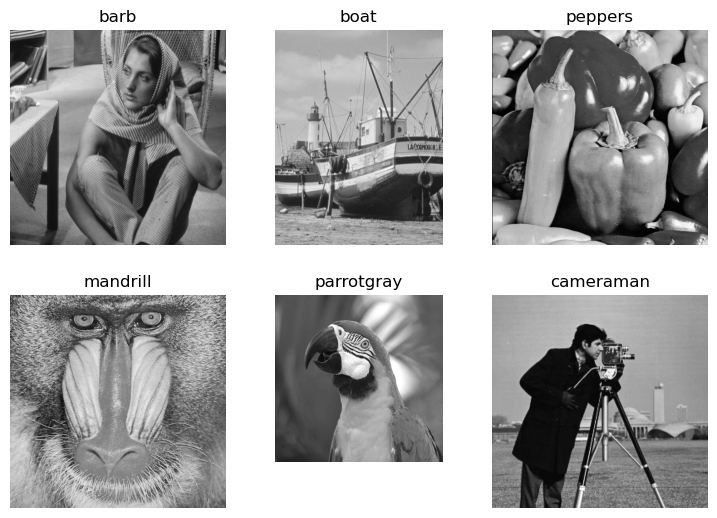

In [3]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )
for ax, name in zip(grid, ['barb', 'boat', 'peppers', 'mandrill', 'parrotgray', 'cameraman']):
    img = plt.imread(f"img/{name}.png")
    if img.ndim > 2:
        img = img[..., 0]
    # Iterating over the grid returns the Axes.
    ax.imshow(img, cmap="gray")
    ax.set_title(name)
    ax.axis('off')

plt.show()

Text(0.5, 1.0, 'Original image')

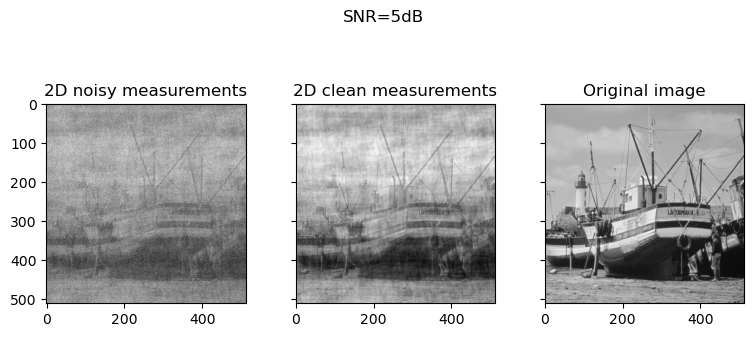

In [4]:
import matplotlib.pyplot as plt
from mlsp.utils.lab_utils import load_and_normalize_image, generate_2d_cs_data

# Load and normalize the image
image_path = "img/boat.png"
image = load_and_normalize_image(image_path, device=device)

# Generate 2D compressed sensing data
percent = 0.60
isnr = 5
rng = torch.Generator(device=device)
observations, sensing_operator, sigma, clean_observations = generate_2d_cs_data(image, percent, isnr, rng=rng)
im_inpainting_noisy = sensing_operator.adjoint(observations)

fig = plt.figure(figsize=(9, 4))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

fig.suptitle(f'SNR={isnr}dB')
# Plot the measurements in 2D
grid[0].imshow(im_inpainting_noisy, cmap="gray")
grid[0].set_title("2D noisy measurements")

# Plot the measurements in 2D
im_inpainting = sensing_operator.adjoint(clean_observations)
grid[1].imshow(im_inpainting, cmap="gray")
grid[1].set_title("2D clean measurements")


# Plot the measurements in 2D
grid[2].imshow(image, cmap="gray")
grid[2].set_title("Original image")

In [5]:
torch.sqrt(torch.linalg.norm(clean_observations).pow(2)/(torch.numel(clean_observations)*10**(isnr/10)))

tensor(38436.1719)

# TV-ADMM regularization

As a baseline, we will consider an ADMM algorithm leveraging a TV regularization of the problem (see tutorial 1), i.e., using $g = \lambda TV(\cdot)$ for $\lambda > 0$.

1. Starting from tutorial 1, complete the [`src/mlsp/model/discrete_gradient.py`](src/mlsp/model/discrete_gradient.py) module to implement the discrete gradient operator and its adjoint. Write a short unit-test to verify the correctness of the implementation of the adjoint operator.

2. Complete the files [`src/mlsp/model/cvx_functions.py`](src/mlsp/model/cvx_functions.py) and [`src/mlsp/model/prox.py`](src/mlsp/model/prox.py) to implement all the building blocks related to the TV regularization involved in the TV-ADMM algorithm.

3. Using tutorial 1, indicate a possible splitting approach to ensure the update steps of the ADMM algorithm are simple to compute. Write the general expression of the resulting update steps.

4. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the ADMM algorithm, either as a function or a class, to solve the optimization problem.

In [6]:
# Q1

_test = torch.randint(0, 10, (3, 3))
print(_test)
from mlsp.model.discrete_gradient import gradient_2d
print(gradient_2d(_test))

tensor([[4, 3, 6],
        [6, 2, 1],
        [7, 0, 4]])
tensor([[[ 2., -1., -5.],
         [ 1., -2.,  3.],
         [ 0.,  0.,  0.]],

        [[-1.,  3.,  0.],
         [-4., -1.,  0.],
         [-7.,  4.,  0.]]])


In [7]:
# Q2



# Loading an existing PnP regularization (denoiser)

- This lab will be based on pre-trained regularization available on github. Read the [`README.md`](README.md) file to retrieve the network weights.

- Once retrieved, an example use for one of the networks is provided below.

In [8]:
from mlsp.model.pnp.network_ffdnet import FFDNet
from mlsp.model.pnp.network_unet import UNetRes

rng = torch.Generator(device="cpu")
rng.manual_seed(1234)

# generating a dummy test image
x0 = torch.normal(0.0, 1.0, (128, 128), generator=rng).to(device)

In [9]:
# loading FFDNet network weights (reference: https://github.com/cszn/KAIR/blob/master/main_test_ffdnet.py)
model_path = "labs/weights/ffdnet_gray.pth"
n_channels = 1  # setting for grayscale image
nc = 64  # setting for grayscale image
nb = 15  # setting for grayscale image
denoiser_ffdnet = FFDNet(in_nc=n_channels, out_nc=n_channels, nc=nc, nb=nb, act_mode="R")
denoiser_ffdnet.load_state_dict(torch.load(model_path), strict=True)
denoiser_ffdnet.eval()
denoiser_ffdnet = denoiser_ffdnet.to(device)

# noise level for the denoiser
noise_level_model = 5.0
sigma = torch.full((1, 1, 1, 1), noise_level_model / 255.0).type_as(x0)

In [10]:
# applying the network (applies by defaut to multiple images in a multi-channel setting, Ni x C x Nx x Ny, with Ni = C = 1 in our case)
x_denoised = torch.squeeze(denoiser_ffdnet(x0[None, None, ...], sigma))
x_denoised.shape

torch.Size([128, 128])

Let's also try another denoiser.

In [ ]:
from mlsp.model.pnp.network_scunet import SCUNet

denoiser_scunet = SCUNet(in_nc=n_channels,config=[4,4,4,4,4,4,4],dim=64)
denoiser_scunet.load_state_dict(torch.load("labs/weights/scunet_gray_15.pth"), strict=True)
denoiser_scunet.eval()
denoiser_scunet = denoiser_scunet.to(device)

In [25]:
# applying the network (applies by defaut to multiple images in a multi-channel setting, Ni x C x Nx x Ny, with Ni = C = 1 in our case)
x_denoised = torch.squeeze(denoiser_scunet(x0[None, None, ...]))
x_denoised.shape

torch.Size([128, 128])

# PnP-ADMM

The plug-and-play (PnP) approach relies on the use of a pre-trained denoiser, encoded in this lab by a neural network. We will mostly use pre-trained networks provided [online on github](https://github.com/cszn/KAIR), see example above.

1. Recall the form of the ADMM and PnP-ADMM algorithms instantiated for the problem considered, expressed in terms a generic denoiser $D_\sigma$, with $\sigma > 0$.

2. Write a simple [`torch`](https://pytorch.org/docs/stable/index.html) implementation of the PnP-ADMM algorithm.
> Hint: 
> - make sure the evolution of the cost function is returned to monitor the behaviour of the algorithm.

## Your answers

1. <p style="color:rgb(137, 207, 240);">Your answer</p>

ADMM solves by alternating the optimization of $\vec{x}$ and $\vec{v}$ with gradient ascent of $\vec{u}$, i.e.,

\begin{align}
\vec{x}_k &= h(\vec{v}_{k-1} - \vec{u}_{k-1};\eta)\\
\vec{v}_k &= prox_{\phi}(\vec{x}_{k} + \vec{u}_{k-1};\eta)\\
\vec{u}_k &= \vec{u}_{k-1} + ( \vec{x}_{k} - \vec{v}_{k}), 
\end{align}


where $h(\vec{z};\eta)$ and $prox_{\phi}(\vec{z};\eta)$, known as 

are defined as

\begin{align}
prox_{\phi}(\vec{z};\eta) &\overset{\delta}{=} \argmin_{\vec{x}} \left\{ \phi(\vec{x}) + \frac{1}{2\eta}\|\vec{x} - \vec{z}\|^2 \right\}  
\\[10pt]
h(\vec{z};\eta) &\overset{\delta}{=} \argmin_{\vec{x}} \left\{ \frac{1}{2\sigma^2} \|\vec{y} - \vec{Ax}\|^2 + \frac{1}{2\eta}\|\vec{x} - \vec{z} \|^2 \right\} 
= prox_{\|\vec{y}-\vec{Ax}\|^2/(2\sigma^2)}(\vec{z};\eta) \\
&= \left(\vec{A}^T\vec{A}+\frac{\sigma^2}{\eta}\vec{I}\right)^{-1}\left(\vec{A}^T\vec{y}+\frac{\sigma^2}{\eta}\vec{z}\right).
\end{align}


We will work with the adjoint of the cs operator. That is we will use the adjoint of the observations to get back the observations as 2D images. So $A=I$.

$$= (\frac{\eta}{\eta \sigma^2}I_d)(y+\frac{\sigma^2}{\eta}z)$$

2. <p style="color:rgb(137, 207, 240);">Your answer</p>

In [26]:
from mlsp.utils.lab_utils import load_and_normalize_image, generate_2d_cs_data

We will load an image and generate 2D data using isnr=30 and the proportion for the inpainting set to 0.6.

In [27]:
x = load_and_normalize_image(
    "img/barb.png", device, max_intensity=None, downsampling=4
)
print("Image size: {}".format(x.shape))

isnr = 30
rng = torch.Generator(device="cpu")
rng.manual_seed(1234)

percent = .6
observations, sensing_operator, sig, clean_observations = generate_2d_cs_data(x, percent, isnr, rng)

obs_2D = sensing_operator.adjoint(observations)

print("Image size: {}".format(x.shape))
print("Number of observations: {}".format(sensing_operator.data_size))



Image size: torch.Size([128, 128])
Image size: torch.Size([128, 128])
Number of observations: torch.Size([4992])


Let's first have a look at the denoisers that we will use in this section.

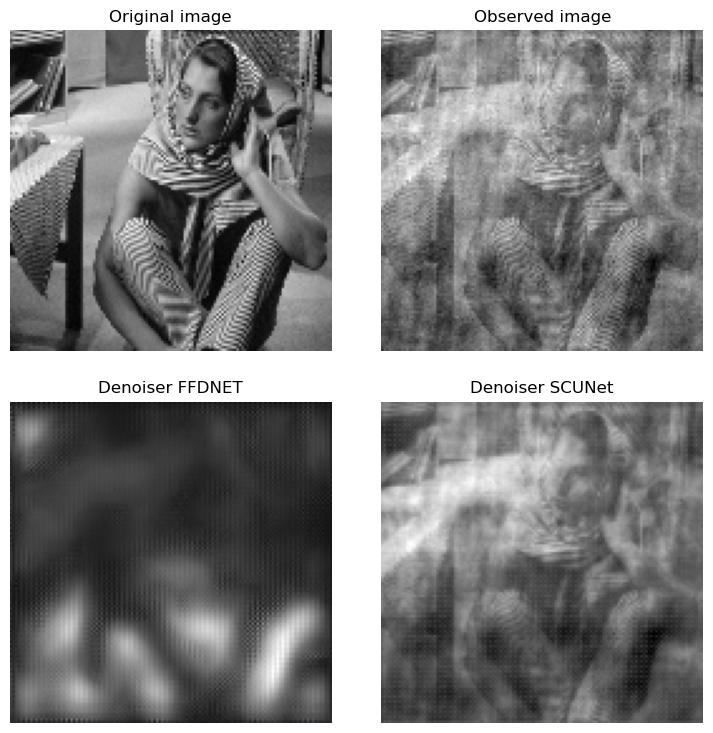

In [28]:
fig = plt.figure(figsize=(9, 9))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
                 )

x_denoised_scunet = denoiser_scunet((obs_2D)[None,None,...]).squeeze().detach().numpy()
x_denoised_ffdnet = denoiser_ffdnet((obs_2D)[None,None,...], torch.tensor([sig])).squeeze().detach().numpy()
for ax, name, im in zip(grid, ['Original image', 'Observed image', 'Denoiser FFDNET', 'Denoiser SCUNet'], [x, obs_2D, x_denoised_ffdnet, x_denoised_scunet]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap="gray")
    ax.set_title(name)
    ax.axis('off')
plt.show()

We can notice a unexpected behaviour for the FFDNet denoiser. Indeed, the image reconstructed lose completely all the details and the original image is not recognizable anymore. This has been observed for different values of sigma provided to the model or for different normalization techniques for the input image. Therefore, we have decided to try another denoiser in order to get a useful model for the experiments. SCUNet has proved to have much better and acceptable results as it can be observed above. We indeed see that high frequencies of the pants of the person are smoothed out.

Let us now try to implement the PnP-ADMM. We will use the results derived in the previous questions for the update steps.

In [29]:
def update_x(sensing_op, x, z, u, lam, sig, observations):
    M = observations.numel()
    N = x.numel()
    left = 1/((N/M) + lam*sig**2)
    right = sensing_op.adjoint(observations) + (sig**2*lam)*(z-u)
    return left*right

def update_z(denoiser, x, u):
    return denoiser((u+x)[None, None, ...]).squeeze()

In [49]:
def normalize(x):
    return (x-x.min()) / (x.max()-x.min())

def rsnr(x, x_ref):
    return 10 * torch.log10(x_ref.norm().pow(2) / (x_ref - x).norm().pow(2))

In [56]:
nstep = 30
lam=1e-1
init_noisy=False
z_k = obs_2D.clone() if init_noisy else torch.zeros_like(obs_2D)
x_k = obs_2D.clone() if init_noisy else torch.zeros_like(obs_2D)
u_k = obs_2D.clone() if init_noisy else torch.zeros_like(obs_2D)

# Empty lists to store some metrics and quantities of interest
ssim_val = []
rsnr = []
x_gap_with_u = []
x_gap_with_z = []
z_gap_with_u = []
x_norm = []
with torch.no_grad():
    for i in range(nstep):
        # Update steps
        x_k = update_x(sensing_operator, x_k, z_k, u_k, lam, sig, observations)
        z_k = update_z(denoiser_scunet, x_k, u_k)
        u_k = u_k+x_k-z_k
        
        # Track some metrics and quantities of interest
        x_norm.append(torch.norm(x_k).item())
        rsnr.append(10*torch.log10(torch.norm(x.flatten()).pow(2)/torch.norm(x.flatten()-x_k.flatten()).pow(2)).item())
        x_gap_with_u.append(torch.norm(x_k-u_k).item())
        x_gap_with_z.append(torch.norm(x_k-z_k).item())
        z_gap_with_u.append(torch.norm(z_k-u_k).item()) 
        ssim_val.append(ssim(normalize(x.cpu().numpy()), normalize(x_k.cpu().numpy()), data_range=1.0))
        print(f"Step {i+1}/{nstep}, SSIM: {ssim_val[-1]:.4f}", end="\r")

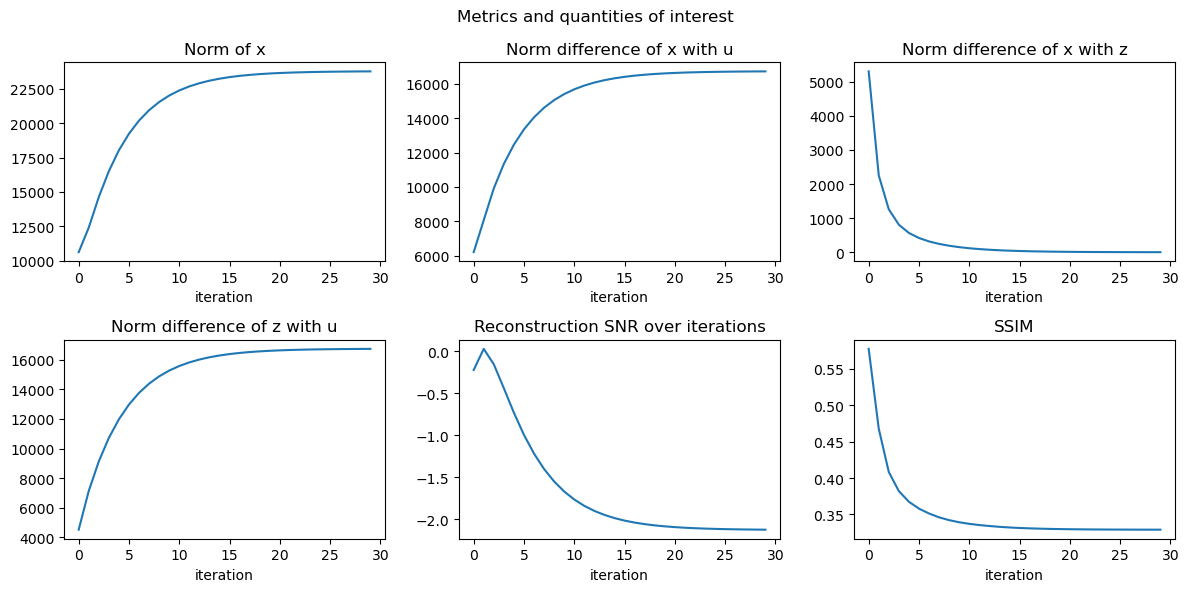

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs[0, 0].plot(x_norm)
axs[0, 0].set_title("Norm of x")
axs[0, 1].plot(x_gap_with_u)
axs[0, 1].set_title("Norm difference of x with u")
axs[0, 2].plot(x_gap_with_z)
axs[0, 2].set_title("Norm difference of x with z")
axs[1, 0].plot(z_gap_with_u)
axs[1, 0].set_title("Norm difference of z with u")
axs[1, 1].plot(rsnr)
axs[1, 1].set_title("Reconstruction SNR over iterations")
axs[1, 2].plot(ssim_val)
axs[1, 2].set_title("SSIM")
for ax in axs.flat:
    ax.set(xlabel='iteration')
fig.suptitle("Metrics and quantities of interest")
plt.tight_layout()
plt.show()

After finetuning the hyperparameter $\lambda$ we get the plots here above that track some quantities of interest. We observe that all our split variables are converging rather quickly. We observe that we get the desired constraint which is $x=z$.

It seems that our criterions are getting bad as we satisfy the constraint $x=z$.

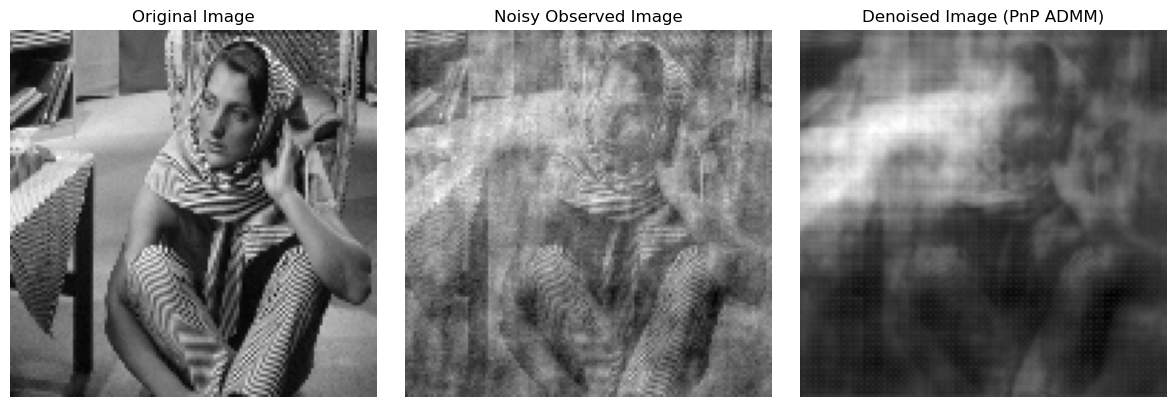

In [58]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(x.cpu().numpy(), cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(obs_2D.cpu().numpy(), cmap='gray')
axs[1].set_title('Noisy Observed Image')
axs[2].imshow(x_k.cpu().numpy(), cmap='gray')
axs[2].set_title('Denoised Image (PnP ADMM)')
for ax in axs.flat:
    ax.axis('off')
plt.tight_layout()
plt.show()


Despite having smooth converging curves we observe that the final result is not satisfiable.Indeed, we kind of only a smoothing the damaged image. The good point is that we still see that we are getting to the goal whereas with the FFDNet denoiser we did not get any result. It is normal since the other denoiser output wrong results that are therefore meaningless in this denoising process.

Since our curves are pretty smooth we think that the problem does not come from the implementation directly but from the way we approached the problem. Indeed, the derivations a seem to be good but we might have not targeted the correct solution.

We thought about imposing the constraint $Ax=z$ instead of $x=z$ but we got diverging results.

In [212]:
def update_x_v3(sensing_op, x, z, u, lam, sig, observations):
    M = observations.numel()
    N = x.numel()
    return (M/N)* +1/(sig**2+1)*sensing_op.adjoint(observations+lam*(z-u))

def update_z(sensing_op, denoiser, x, u, sig):
    temp = sensing_op.adjoint(u)
    return denoiser((temp+x)[None, None, ...]).squeeze()

def update_z_v2(sensing_op, denoiser, x, u, sig):
    return denoiser((u+x)[None, None, ...]).squeeze()

In [ ]:
nstep = 30
lam=1e8
init_noisy=False
z_k = observations.clone() if init_noisy else torch.zeros_like(observations)
x_k = obs_2D.clone() if init_noisy else torch.zeros_like(obs_2D)
u_k = observations.clone() if init_noisy else torch.zeros_like(observations)

ssim_val = []
x_gap_between_iter = []
x_gap_with_u = []
x_gap_with_z = []
z_gap_with_u = []
with torch.no_grad():
    for i in range(nstep):
        x_old = x_k.clone()
        x_k = update_x_v3(sensing_operator, x_k, z_k, u_k, lam, sig, observations)

        z_k = sensing_operator.forward(update_z(sensing_operator, denoiser_scunet, x_k, u_k, sig))
        temp = sensing_operator.forward(x_k)
        u_k = u_k+temp-z_k

        ssim_val.append(ssim(x.cpu().numpy(), x_k.cpu().numpy(), data_range=1.0))
        print(f"Step {i+1}/{nstep}, SSIM: {ssim_val[-1]:.4f}", end="\r")

# Results and comparisons

1. 
   1. Recall the definition of the reconstruction signal to noise ratio (rSNR). 
   
   2. Which limitation do you see with this criterion when it comes to assessing the reconstruction of low-amplitude coefficients in the unknown parameter? Is this criterion enough to fully assess the performance of an algorithm.
   
   3. Implement a `torch` function to compte the rSNR.

2. Visually compare the results obtained with the TV-ADMM and PnP-ADMM algorithms, as well as the evolution of the cost function over the iterations.

3. Evaluate the reconstruction performance in terms of rSNR and structural similarity index ([SSIM](https://scikit-image.org/docs/stable/auto_examples/transform/plot_ssim.html))

4. Conclude on the performance of these approaches. Identify some of their limits.

## Your answers

1. 
   1. <p style="color:rgb(137, 207, 240);">Your answer</p>



The reconstruction signal to noise ratio in dB is defined as following:

$$ \textrm{rSNR}=10\log_{10} \biggl(\frac{\lVert x \rVert_2^2}{\lVert x-\hat{x} \rVert_2^2}\biggr)$$

with $x$ the target signal and $\hat{x}$ the reconstructed signal.

1.
   2. <p style="color:rgb(137, 207, 240);">Your answer</p>

The rSNR is very sensitive to noise and higher values meaning that low coefficients will not have a large weight in the computation of the rSNR. However in some cases these low values might be of big importance. We might want to have some criterions that are looking at the spatial structure of the reconstructed image. The FID (Fréchet Inception Distance) or SSIM might be very interesting when dealing with images for example.

1.
   3. <p style="color:rgb(137, 207, 240);">Your answer</p>


In [59]:
def rsnr(x, x_ref):
    return 10 * torch.log10(x_ref.norm().pow(2) / (x_ref - x).norm().pow(2))


2. <p style="color:rgb(137, 207, 240);">Your answer</p>
3. <p style="color:rgb(137, 207, 240);">Your answer</p>

To get correct values of SSIM we normalize the ground truth and the reconstructed image to get them in the same range of values. We are getting stuck to quite low values of SSIM and rSNR for the reasons mentionned above. The rSNR is very bad but when we look at the SSIM we see that we are still reconstructing something interesting. This has indeed been seen visually.


4. <p style="color:rgb(137, 207, 240);">Your answer</p>

# Bonus: implementation using the `deepinv` library

The [`deepinv`](https://github.com/deepinv/deepinv) library offers a pre-defined set of algorithms and modeling blocks to solve inverse problems with PnP priors.

1. Take a look at the [documentation](https://deepinv.github.io/deepinv/index.html) and the [provided examples](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_DPIR_deblur.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-dpir-deblur-py). Use one of the optimization algorithms available in the library for comparison with the PnP-ADMM algorithm implemented above.

2. Compare the results obtained to those of your implementation in terms of reconstruction performance and timing.

> Hints:
> - Take a look at the [tutorial example](https://deepinv.github.io/deepinv/auto_examples/plug-and-play/demo_PnP_custom_optim.html#sphx-glr-auto-examples-plug-and-play-demo-pnp-custom-optim-py) to see how to combine the different ingredients made available in the library.

In [190]:
# your code (mostly call to functions you need to implement in a Python module)